In [1]:
from matplotlib import pyplot as plt 

In [2]:
import json

In [3]:
import re

In [4]:
import numpy as np

In [5]:
def bucket(x, size):
    l = len(x)
    buckets = []
    i = 0
    while i < l:
        buckets.append(sum(x[i:i+size])/len(x[i:i+size]))
        i+=size
    return buckets

In [6]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [7]:
class LogReader():
    def __init__(self, filename, keys):
        self.file = open(f'{filename}')
        self.keys = set(keys)
        self.matches = {}
        for key in keys:
            self.matches[key]=[]
    
    def grab(self):
        line = next(self.file, None)
        while line:
            split = line.strip().split('=')
            if len(split)==2:
                query = split[0]
                value = float(split[1])
                if query in self.keys:
                    self.matches[query].append(value)
            line = next(self.file, None)
        return self.matches

In [8]:
tasks = [
    ('atac_region', 'gene'),
    ('gene', 'atac_region'),
    ('gene', 'protein_name'),
    ('protein_name', 'gene'),
]

In [9]:
base_keys = [
    'train zero one loss',
    'train value loss',
    'train prediction loss',
    'validation zero one loss',
    'validation value loss',
    'validation prediction loss',
]

keys = []
for key in base_keys:
    for task in tasks:
        keys.append(f'{key} {task}')

In [10]:
keys += [
    'Batch',
    'Epoch',
]

#### Bucket Size

In [11]:
bucket_size = 10

In [12]:
readers = {}
matches = {}

#### Timestamp of run

In [13]:
timestamps = [
    '20220709-1339', # full graph, SAGE 5 layers, 64 width
    '20220824-1408', # full graph, GAT 4 layers
    '20220824-1415', # full graph, SAGE 3 layers 
    '20220825-1516', # reduced graph, SAGE 5 layers, 64 width
    '20220825-1548', # reduced graph, SAGE 3 layers, 768 width
    
]
files = [f'logs/train_earl_{tmstp}.log' for tmstp in timestamps]

In [14]:
for file in files:
    if file not in readers:
        readers[file] = LogReader(file, keys)
        matches = readers[file].grab()

# Select File

In [79]:
idx = 1

## Get matching log lines

In [95]:
file = files[idx]
matches = readers[file].grab()

## Parameters of this run

In [96]:
import json
from pprint import pprint

In [97]:
params = json.load(open(f'logs/earl_params_{timestamps[idx]}.json'))
pprint(params)

{'atac_ones_weight': 1,
 'checkpoint': 25,
 'device': 'cuda:0',
 'gene_ones_weight': 1,
 'layers': [['GATConv', {'heads': 2, 'out_channels': 32}],
            ['GATConv', {'heads': 2, 'out_channels': 32}],
            ['GATConv', {'heads': 2, 'out_channels': 32}],
            ['GATConv', {'heads': 2, 'out_channels': 32}]],
 'lr': 0.001,
 'n_steps': 30000,
 'out_mlp': {'bias': True,
             'dim_in': 64,
             'dim_inner': 512,
             'dim_out': 1,
             'num_layers': 3},
 'train_batch_size': 500,
 'validation_batch_size': 100}


In [98]:
batch_size = params['train_batch_size']

## Current Batch

In [99]:
batch = int(matches['Batch'][-1])
batch

3707

## Num examples seen

In [100]:
batch*batch_size

1853500

## Training loss

In [101]:
from matplotlib import cm

('atac_region', 'gene') 0.3412
('gene', 'atac_region') 0.4071
('gene', 'protein_name') 0.3923
('protein_name', 'gene') 0.3217


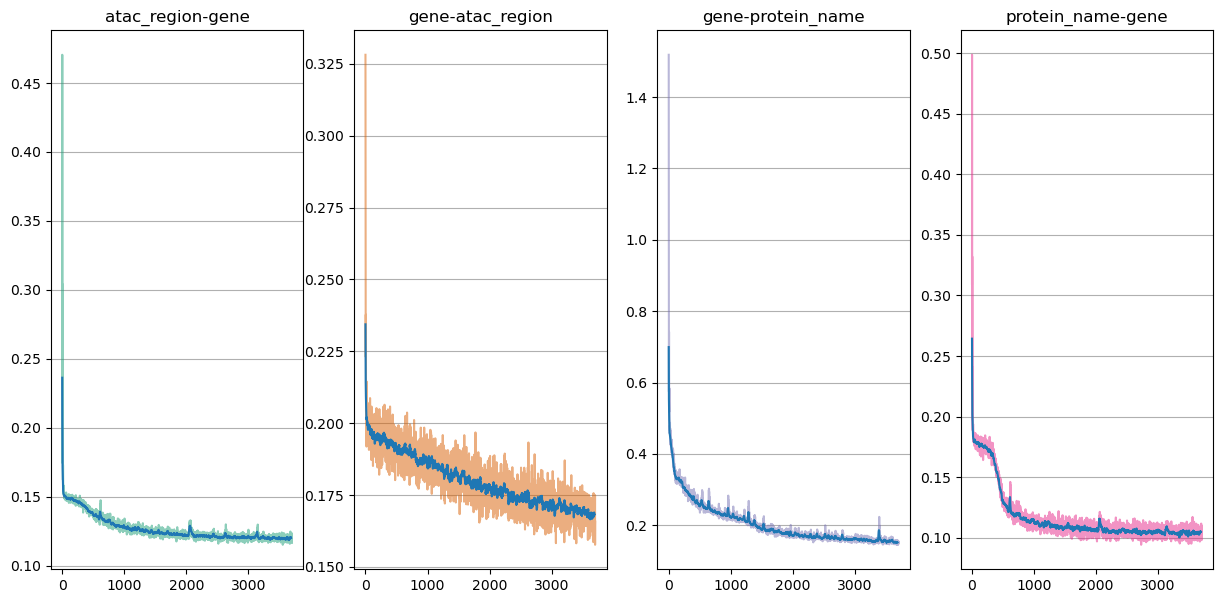

In [102]:
fig,ax = plt.subplots(1, 4, figsize=(15,7))

cmap = cm.Dark2

start = 5
width = 15

for i,task in enumerate(tasks):
    training_loss = matches[f'train prediction loss {task}']
    color = list(cmap(i))
    color2 = list(color) 
    color2[3] = .5
    ax[i].plot(training_loss[start:], label=f'{task[0]}-{task[1]}', c=color2)
    ax[i].plot(moving_average(training_loss[start:],width))
    ax[i].grid(axis='y')
    ax[i].set_title(f'{task[0]}-{task[1]}')
#     ax.plot(bucket_steps, bucket(training_loss[batch_size:],5), c=color)
    print(task, f'{np.sqrt(training_loss[-1]):.4f}')
# _=ax[0].legend()


## Validation Loss

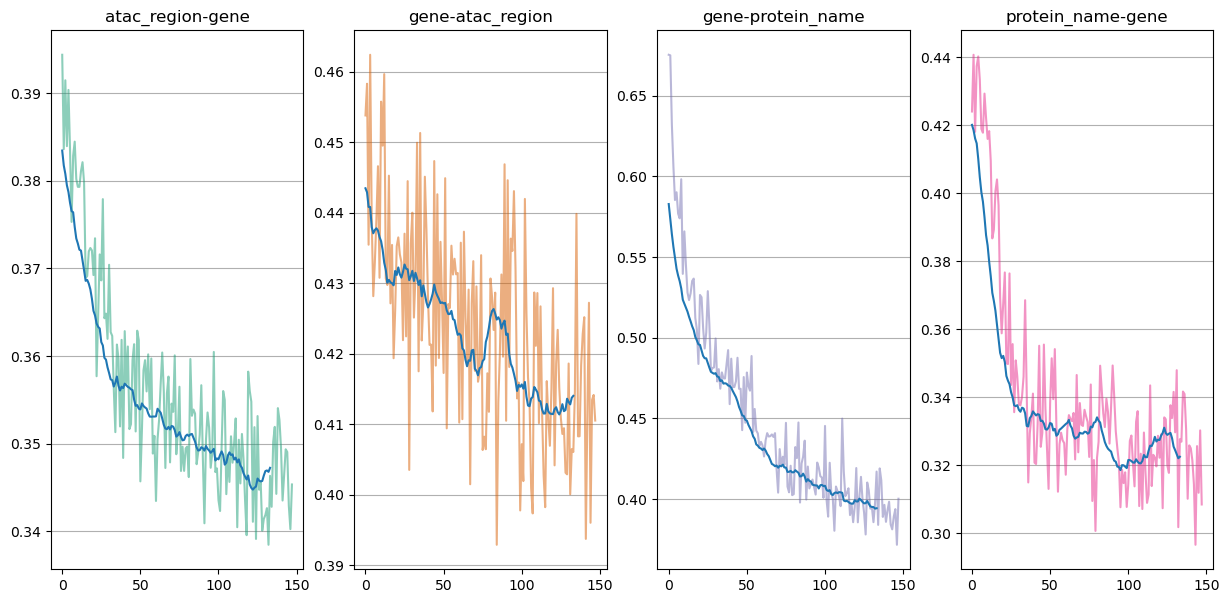

In [103]:
fig,ax = plt.subplots(1,4, figsize=(15,7))

for i,task in enumerate(tasks):
    validation_loss = matches[f'validation prediction loss {task}']
    color = list(cmap(i))
    color2 = list(color) 
    color2[3] = .5
    ax[i].plot(np.sqrt(validation_loss[1:]), label=f'{task[0]}-{task[1]}', c=color2)
    ax[i].plot(moving_average(np.sqrt(validation_loss)[1:],width))
    ax[i].grid(axis='y')
    ax[i].set_title(f'{task[0]}-{task[1]}')


In [104]:
for i,task in enumerate(tasks):
    validation_loss = matches[f'validation prediction loss {task}']
    print(task, f'{np.sqrt(validation_loss[-1]):.3f}')


('atac_region', 'gene') 0.345
('gene', 'atac_region') 0.411
('gene', 'protein_name') 0.400
('protein_name', 'gene') 0.308


### Neurips results (RMSE)

atac gene = .22

gene atac = .17

gene protein = .39

protein gene = .32

## Sample predictions

In [105]:
import re

In [106]:
batch_re = re.compile('^batch')

In [107]:
import time

In [108]:
prediction_file = open(f'logs/train_earl_prediction_sample_{timestamps[idx]}.log')

ls = []

for i,line in enumerate(prediction_file):
    l = line.strip()
    if batch_re.match(l) and i%5==0:
        ls.append(l)
    elif not batch_re.match(l):
        ls.append(l)
        
for l in ls:
    time.sleep(.005)
    print(l)
    time.sleep(.01)
    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



batch 3700 47     pred,y:   0.018 0.000
batch 3700 52     pred,y:   0.064 0.000
batch 3700 57     pred,y:   0.052 0.000
batch 3700 62     pred,y:  -0.000 0.000
batch 3700 67     pred,y:   0.109 0.000
batch 3700 72     pred,y:   0.032 0.000
batch 3700 77     pred,y:   0.113 0.000
batch 3700 82     pred,y:   0.066 0.000
batch 3700 87     pred,y:   0.027 0.000
batch 3700 92     pred,y:   0.091 0.000
batch 3700 97     pred,y:   0.038 0.000
batch 3700 102    pred,y:   0.036 0.000
batch 3700 107    pred,y:   0.090 0.000
batch 3700 112    pred,y:   0.091 0.000
batch 3700 117    pred,y:   0.068 0.000
batch 3700 122    pred,y:   0.052 0.000
batch 3700 127    pred,y:   0.160 0.000
batch 3700 132    pred,y:   0.646 0.000
batch 3700 137    pred,y:   0.058 0.000
batch 3700 142    pred,y:   0.068 0.000
batch 3700 147    pred,y:  -0.005 0.000
batch 3700 152    pred,y:   0.053 0.000
batch 3700 157    pred,y:   0.109 0.000
batch 3700 162    pred,y:   0.051 0.000
batch 3700 167    pred,y:   0.119 0.000


batch 3700 294    pred,y:   0.034 0.000
batch 3700 299    pred,y:   0.009 0.000


In [109]:
[(i,np.log10(i+.1)) for i in range(1,100)]

[(1, 0.04139268515822507),
 (2, 0.3222192947339193),
 (3, 0.4913616938342727),
 (4, 0.6127838567197355),
 (5, 0.7075701760979364),
 (6, 0.785329835010767),
 (7, 0.8512583487190752),
 (8, 0.9084850188786497),
 (9, 0.9590413923210935),
 (10, 1.0043213737826426),
 (11, 1.0453229787866574),
 (12, 1.08278537031645),
 (13, 1.1172712956557642),
 (14, 1.14921911265538),
 (15, 1.1789769472931695),
 (16, 1.2068258760318498),
 (17, 1.2329961103921538),
 (18, 1.2576785748691846),
 (19, 1.2810333672477277),
 (20, 1.3031960574204888),
 (21, 1.3242824552976926),
 (22, 1.3443922736851108),
 (23, 1.3636119798921444),
 (24, 1.3820170425748683),
 (25, 1.3996737214810382),
 (26, 1.416640507338281),
 (27, 1.4329692908744058),
 (28, 1.4487063199050798),
 (29, 1.4638929889859074),
 (30, 1.4785664955938433),
 (31, 1.4927603890268375),
 (32, 1.506505032404872),
 (33, 1.5198279937757189),
 (34, 1.5327543789924978),
 (35, 1.545307116465824),
 (36, 1.557507201905658),
 (37, 1.5693739096150459),
 (38, 1.5809249756